# 🏗️ Sesión 01: Ingeniería de ML y Pipelines Robustos

## 📑 Índice
1.  [Carga de Datos y Split Inicial](#1.-Carga-de-Datos-y-Split-Inicial) 📦
2.  [Definición de Selectores](#2.-Definición-de-Selectores) 🔍
3.  [Construcción de Pipelines Específicos](#3.-Construcción-de-Pipelines-Específicos) ⚙️
4.  [El ColumnTransformer (El "Router")](#4.-El-ColumnTransformer-(El-"Router")) 🔀
5.  [El Pipeline Final](#5.-El-Pipeline-Final-(Preprocesamiento-+-Modelo)) 🚀
6.  [Entrenamiento y Evaluación](#6.-Entrenamiento-y-Evaluación) 📊
7.  [Serialización](#7.-Serialización-(Guardar-para-Producción)) 💾

---

## 💼 Caso de Negocio: Credit Scoring
**Contexto:** Eres el Lead Data Scientist en "Financiera Futuro". El equipo de riesgos necesita un modelo para predecir si un cliente caerá en impago (default) en los próximos 2 años.
**El Problema:** El equipo anterior entregó un modelo que falló en producción porque el código era un "spaghetti" inmantenible y tenía data leakage.
**Tu Misión:** Construir un **Pipeline de Scikit-Learn** robusto, reproducible y listo para producción que transforme los datos crudos y entrene un modelo base (Logistic Regression) sin cometer errores de principiante.

## 🎯 Objetivos de Aprendizaje
1.  **Estandarización:** Usar `Pipeline` y `ColumnTransformer` para encapsular el preprocesamiento.
2.  **Pandas Nativo:** Configurar Scikit-Learn para que devuelva DataFrames en lugar de numpy arrays.
3.  **Baseline:** Establecer una métrica base con un modelo lineal simple pero bien hecho.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Agregado para visualizaciones
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
# Agregado ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay
from category_encoders import TargetEncoder
import joblib

from sklearn import set_config
set_config(transform_output="pandas")


> **💡 Pro-Tip de Producción:**
> Desde Scikit-Learn 1.2, podemos usar `set_config(transform_output="pandas")`.
> Esto es un **game changer** para debuggear pipelines, ya que no perdemos los nombres de las columnas al transformar los datos. ¡Adiós a adivinar qué columna es `x[0]`!

## 1. Carga de Datos y Split Inicial
**Regla de Oro:** Dividir antes de tocar nada.

In [ ]:
from recursos.utils import load_data
import sys
import os
sys.path.append(os.path.abspath('../../'))

df = load_data('credit_scoring.csv')

# Ver columnas disponibles
print("Columnas:", df.columns.tolist()[:10], "...")
print(f"Dimensiones: {df.shape}")

# Separar Features y Target
# Nota: La columna target es 'target_y' (1=default, 0=no default)
TARGET_COL = 'target_y'
COLS_TO_DROP = [TARGET_COL, 'malo_sf_inicio',
                'periodo', 'Unnamed: 0']  # Columnas auxiliares

# ✅ SOLUCIÓN ANTI-PATTERN 3 (IDs como Features):
# Eliminamos explícitamente columnas que no aportan valor predictivo o son identificadores.
X = df.drop([col for col in COLS_TO_DROP if col in df.columns], axis=1)
y = df[TARGET_COL]

# ✅ SOLUCIÓN ANTI-PATTERN 1 (Data Leakage):
# Dividimos en Train/Test ANTES de calcular cualquier estadística (media, moda, etc.).
# Split Estratificado (importante en desbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(
    f"Distribución target (Train): {y_train.value_counts(normalize=True).to_dict()}")


Columnas: ['Unnamed: 0', 'banca', 'tipocredito', 'sector_final', 'tipocontribuyente', 'NumeroTrabajadores', 'MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTFIN_12M', 'MAX_CNT_ENTIDADES_SSFF_06M', 'SD_MAX_DIAS_MORA_SSFF_06M', 'CAT_ENTFIN_PRINCIPAL_01M'] ...
Dimensiones: (7180, 30)

Train shape: (5744, 26)
Test shape: (1436, 26)
Distribución target (Train): {0: 0.7552228412256268, 1: 0.24477715877437325}


### ⚠️ Real-World Warning: Validación Temporal (OOT)
En este ejercicio usamos `train_test_split` aleatorio, que es estándar para aprender. Sin embargo, en **Credit Scoring** y fraudes, el tiempo es crítico.
*   **El Problema:** El comportamiento de los clientes cambia con la economía (inflación, crisis). Un split aleatorio asume que el futuro es igual al pasado.
*   **En la Vida Real:** Se usa **Out-of-Time (OOT) Validation**.
    *   *Train:* Enero a Junio.
    *   *Test:* Julio y Agosto.
    *   *Objetivo:* Ver si el modelo aguanta el paso del tiempo.

### 📂 Diccionario de Datos (Credit Scoring)
Estamos trabajando con un dataset real de **Riesgo de Crédito para Empresas**.
El objetivo es predecir si una empresa caerá en incumplimiento de pago (`target_y = 1`) en los próximos meses.

**Variables Clave:**
*   `target_y`: **Variable Objetivo**. 1 = Cliente Incumplidor (Bad), 0 = Cliente Cumplidor (Good).
*   `banca`, `sector_final`: Segmentación del cliente (Categóricas).
*   `NumeroTrabajadores`: Tamaño de la empresa.
*   `MAX_PORC_DEUDA...`: Variables de comportamiento financiero en el sistema (Deuda, Sobregiros).
*   `EF_...`: Variables de Estados Financieros (Ratios de liquidez, rotación, etc.).
*   `periodo`: Mes de la evaluación (YYYYMM).

### 🛠️ Micro-Desafío: Preprocesamiento
Intenta cambiar la estrategia del `SimpleImputer` numérico.
En lugar de usar la **mediana** (`strategy='median'`), usa la **media** (`strategy='mean'`).

*   ¿Cambia algo en el AUC final?
*   ¿Por qué crees que la mediana suele ser más robusta en datos financieros?

## 2. Definición de Selectores
Identificamos qué columnas son numéricas y cuáles categóricas.

In [ ]:
# Identificar tipos de columnas automáticamente
num_features = X_train.select_dtypes(
    include=['int64', 'float64']).columns.tolist()
cat_features = X_train.select_dtypes(
    include=['object', 'category']).columns.tolist()

print(f"Features numéricas ({len(num_features)}): {num_features[:5]}...")
print(
    f"Features categóricas ({len(cat_features)}): {cat_features[:5] if cat_features else 'Ninguna'}")

# Verificar valores nulos
null_pct = (X_train.isnull().sum() / len(X_train)
            * 100).sort_values(ascending=False)
print(f"\nColumnas con más nulos:\n{null_pct.head()}")


Features numéricas (21): ['NumeroTrabajadores', 'MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTFIN_12M', 'MAX_CNT_ENTIDADES_SSFF_06M', 'SD_MAX_DIAS_MORA_SSFF_06M', 'CAT_ENTFIN_PRINCIPAL_01M']...
Features categóricas (5): ['banca', 'tipocredito', 'sector_final', 'tipocontribuyente', 'CAT_PRODUCTOS_SSFF_01M']

Columnas con más nulos:
MAX_PORC_DEUDA_SOBREGIRO_CUENTA_CORRIENTE_ENTFIN_12M    38.875348
SITUACION_2_PERIODO                                     18.871866
EF_VAR_INMUEBLE_MAQ_EQUIPO_2a                            5.396936
EF_VAR_VENTAS_2a                                         4.717967
AUDITADO_2_PERIODO                                       4.213092
dtype: float64


## 3. Construcción de Pipelines Específicos

### ⚠️ Real-World Warning: No todos los Nulos son iguales
Aquí usaremos `SimpleImputer(strategy='median')` por simplicidad, pero cuidado:
1.  **Nulos Estructurales:** Si la variable `Deuda_Tarjeta` es `NaN`, ¿significa que perdimos el dato o que el cliente **NO tiene tarjeta**?
    *   *Correcto:* Imputar con 0 o crear una bandera `Tiene_Tarjeta=0`.
    *   *Incorrecto:* Imputar con la mediana de la deuda de otros (le inventamos una deuda).
2.  **Nulos Informativos:** A veces, el hecho de no entregar información (ej. no declarar ingresos) es un predictor de riesgo en sí mismo.
*   **Consejo Pro:** Antes de imputar a ciegas, investiga el **origen** del nulo.

In [ ]:
# Pipeline Numérico: Imputación + Escalado
num_pipeline = Pipeline([
    # ✅ SOLUCIÓN ANTI-PATTERN 1 (Data Leakage):
    # El imputer calculará la mediana SOLO con los datos de X_train durante el .fit()
    ('imputer', SimpleImputer(strategy='median')),

    # ✅ SOLUCIÓN ANTI-PATTERN 4 (Olvido del Escalado):
    # Escalamos las variables para que modelos como Regresión Logística converjan.
    # ⚠️ WARNING: Si tus datos tienen muchos outliers extremos, StandardScaler puede fallar.
    # En ese caso, considera usar RobustScaler() que usa rangos intercuartílicos.
    ('scaler', StandardScaler())
])

# Pipeline Categórico (Placeholder por si hubiera)
# Nota: TargetEncoder de category_encoders usa 'min_samples_leaf' en lugar de 'smoothing'
cat_pipeline = Pipeline([
    # ✅ SOLUCIÓN ANTI-PATTERN 1 (Reproducibilidad):
    # Si llega un nulo en producción, lo llenamos con 'missing' automáticamente.
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),

    # ✅ SOLUCIÓN ANTI-PATTERN 2 (Fragilidad):
    # TargetEncoder (o OneHotEncoder) maneja categorías nuevas en test/producción sin romper el código.
    ('encoder', TargetEncoder(min_samples_leaf=10))
])


## 4. El ColumnTransformer (El "Router")
Une los pipelines específicos.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)  # Comentar si NO hay categóricas
    ],
    verbose_feature_names_out=False,
    remainder='drop'  # Lo que no listamos, se borra
)

# Visualizar el preprocesador (sin ajustar aún)
preprocessor


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


## 5. El Pipeline Final (Preprocesamiento + Modelo)
Usamos `LogisticRegression` con `class_weight='balanced'` para manejar el desbalance de clases (pocos morosos).

In [ ]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        class_weight='balanced', solver='liblinear', random_state=42))
])


### ⚠️ Real-World Warning: Probabilidades Calibradas
Al usar `class_weight='balanced'`, estamos forzando al modelo a dar más importancia a la clase minoritaria (los morosos).
*   **Efecto Secundario:** Las probabilidades que predice el modelo (`predict_proba`) estarán **distorsionadas** (serán más altas de lo real).
*   **Solución:** Si el negocio necesita saber la probabilidad exacta de impago (ej. para calcular la tasa de interés), debes aplicar **Calibración de Probabilidades** (usando `CalibratedClassifierCV`) después de entrenar.

## 6. Entrenamiento y Evaluación

In [ ]:
# Entrenamos todo el flujo de una sola vez
model_pipeline.fit(X_train, y_train)

# Predicciones
# ✅ SOLUCIÓN ANTI-PATTERN 5 (Evaluar en Train):
# Generamos predicciones sobre el conjunto de TEST (que el modelo nunca vio) para tener una métrica honesta.
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

# Métricas
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


              precision    recall  f1-score   support

           0       0.92      0.79      0.85      1084
           1       0.55      0.78      0.64       352

    accuracy                           0.79      1436
   macro avg       0.73      0.79      0.75      1436
weighted avg       0.83      0.79      0.80      1436

ROC-AUC Score: 0.8591


<Figure size 800x600 with 0 Axes>

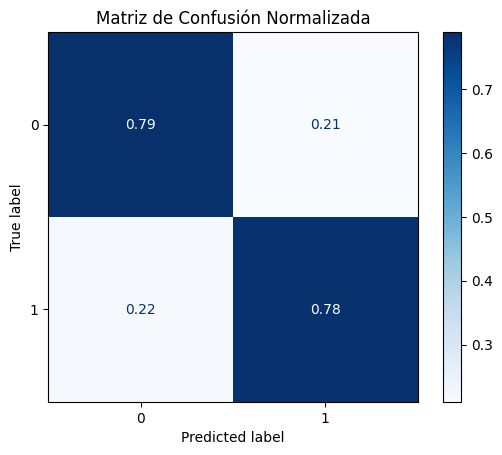

In [ ]:
# Visualización de Resultados
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    model_pipeline, X_test, y_test, cmap='Blues', normalize='true')
plt.title("Matriz de Confusión Normalizada")
plt.show()


### ⚠️ Real-World Warning: El Negocio manda (Cost-Sensitive Learning)
Un AUC de 0.85 se ve bien en el paper, pero en el banco lo que importa es el dinero.
*   **Falso Positivo:** Rechazamos a un buen cliente -> Perdemos intereses (Costo de Oportunidad).
*   **Falso Negativo:** Le prestamos a quien no paga -> Perdemos el capital (Pérdida Directa).
*   **Consejo:** Generalmente, un Falso Negativo es mucho más caro (10x o 20x) que un Falso Positivo. En producción, no usamos el umbral de 0.5; movemos el umbral de decisión para minimizar el **Costo Esperado**, no para maximizar el Accuracy.

## 7. Serialización (Guardar para Producción)
Guardamos el objeto `model_pipeline` completo. Contiene las reglas de imputación, escalado y el modelo.

In [ ]:
joblib.dump(model_pipeline, 'baseline_pipeline.joblib')
print("Pipeline guardado exitosamente.")


Pipeline guardado exitosamente.


---
## 🏆 Resumen de Logros
¡Felicidades! Has construido un pipeline profesional que:
1.  **Es Reproducible:** Cualquier persona puede ejecutar `model_pipeline.predict(nuevo_dato)` y obtendrá el mismo resultado, con las mismas transformaciones.
2.  **Evita Data Leakage:** El split se hizo al principio y los transformadores (`StandardScaler`, `Imputer`) se ajustaron solo con `X_train`.
3.  **Maneja Nulos y Tipos:** No importa si llegan nulos en producción, el pipeline sabe qué hacer.
4.  **Es un Baseline Sólido:** Tienes un AUC de referencia para intentar superar con modelos más complejos (XGBoost, LightGBM) en las próximas sesiones.

👉 **Siguiente Paso:** Ahora que tenemos un baseline, ¿cómo sabemos si es el mejor modelo posible? En la próxima sesión veremos **Optimización de Hiperparámetros**.